# Multi-Scenario MORDM

Multi-scenario MORMD is an extension of normal MORDM to better include robustness considerations within the search phase. It starts from the scenario discovery results resulting from MORDM. Next, from the experiments within this box, a set of scenarios is selected. 

There are many ways of selecting the additional scenarios. The original paper which introduced multi-scenario MORMD [Watson and Kaspzryk (2017)](https://doi.org/10.1016/j.envsoft.2016.12.001) did it in a more or less adhoc manner. [Eker and Kwakkel (2018)](https://doi.org/10.1016/j.envsoft.2018.03.029) introduced a more formal selection approach, the code of which can be found on [GitHub](https://github.com/sibeleker/MORDM---Multi-scenario-search). 

For this assignment, make an informed selection of 4 scenarios, using an approach of your choice. Motivate carefully your selection procedure. 


In [1]:
from ema_workbench import load_results

experiments, outcomes = load_results('mordm_42.tar.gz')
y = outcomes['utility'] < 0.35

there are many ways in which you can make an informed selection. Examples include
* pick best and worst for each outcome of interest
* maximize diversity following Eker & Kwakkel
* visually selected them

Regardless of the used procedure, what matters is that you motivate which scenarios you have selected and why. We start here from the results from the scenario discovery performed in assignment 8

## best case, worst case

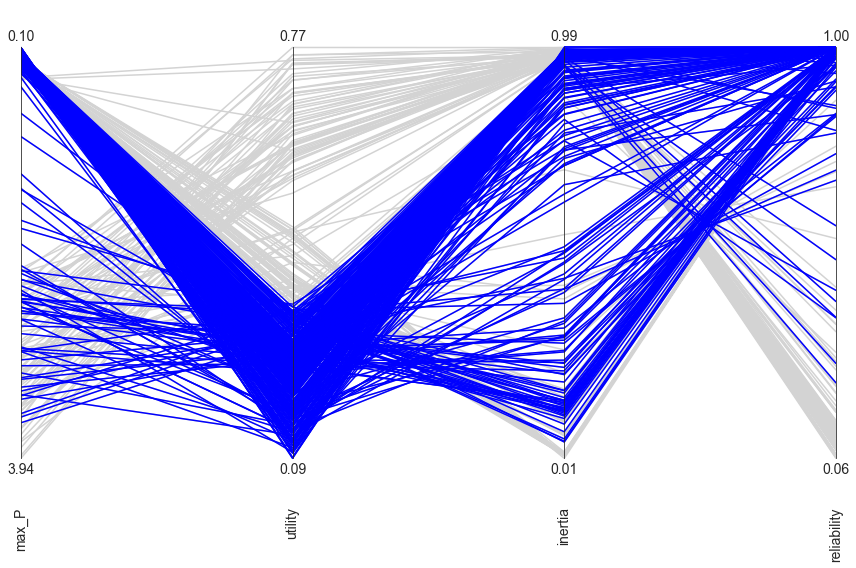

In [2]:
from ema_workbench.analysis import parcoords

# conditional on y
data = pd.DataFrame({k:v[y] for k,v in outcomes.items()})
all_data = pd.DataFrame({k:v for k,v in outcomes.items()})

limits = parcoords.get_limits(all_data)
axes = parcoords.ParallelAxes(limits)
axes.plot(all_data, color='lightgrey')
axes.plot(data, color='blue')
axes.invert_axis('max_P')
plt.show()

In [3]:
print(data.idxmax())
print(data.idxmin())

max_P          158
utility        110
inertia        114
reliability      0
dtype: int64
max_P          141
utility        121
inertia        201
reliability     71
dtype: int64


we now have 8 indices, so we could optimize for each of these 8 scenarios. This might be a bit overkil, so you could also take a worst case stance. In that case,  you would use the max for max_P and the minimum for the others.

In [4]:
# also all we need are the uncertainty columns
selected = experiments.loc[[158, 121, 201, 71], ['b', 'delta', 'mean', 'q', 'stdev']]
selected

,b,delta,mean,q,stdev
158,0.409083,0.946750,0.030473,2.652245,0.001640
121,0.290326,0.931740,0.049042,3.294834,0.002589
201,0.295521,0.936292,0.041696,4.427014,0.004517
71,0.367698,0.945332,0.031303,2.856285,0.004725


In [5]:
from ema_workbench import Scenario

scenarios = [Scenario(f"{index}", **row) for index, row in selected.iterrows()]
    

## Eker & Kwakkel
this code is adapted from the source found in the github repository. The main change is a switch to use a DataFrame for the outcomes, rather than the dictionary as returned by the workbench. 


In [6]:
from sklearn import preprocessing

experiments_of_interest = experiments.loc[y]
outcomes_df = pd.DataFrame({k:v[y] for k,v in outcomes.items()})

# normalize outcomes on unit interval to ensure equal weighting of outcomes
x = outcomes_df.values 
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
normalized_outcomes = pd.DataFrame(x_scaled, columns=outcomes_df.columns)


In [7]:
import itertools

n_scen = experiments.loc[y].shape[0]
indices = range(n_scen)
set_size = 4
n_scen
combinations = itertools.combinations(indices, set_size)
combinations = list(combinations)

While reviewing the code on GitHub, I spotted a terible inefficiency. We were repeatedly calculating the distances between the same pairs of scenarios. I modified the code below to calculate the distances for all scenarios only once. Next, we substract the distances relevant for a given scenario subset,and use this subset for calculating the diversity metric.

In [8]:
from scipy.spatial.distance import pdist, squareform

def evaluate_diversity_single(indices, distances, weight=0.5, distance='euclidean'):
    '''
    takes the outcomes and selected scenario set (decision variables), 
    returns a single 'diversity' value for the scenario set.
    outcomes : outcomes dictionary of the scenario ensemble
    decision vars : indices of the scenario set
    weight : weight given to the mean in the diversity metric. If 0, only minimum; if 1, only mean
    '''
    i, j = [e for e in zip(*itertools.combinations(indices, 2))]
    subset_distances = distances[i, j]
    minimum = np.min(subset_distances)
    mean = np.mean(subset_distances)
    diversity = (1-weight)*minimum + weight*mean
    
    return [diversity]


def find_maxdiverse_scenarios(distances, combinations):
    scores = []
    for indices in combinations:
        diversity = evaluate_diversity_single(indices, distances)
        scores.append((diversity, indices))

    return scores

In [9]:
print(len(combinations))

382313855


the numbere of possible subsets is very large, close to 400 million. Rather than solve this in one for loop, let's split this up over the multiple cores of our machines. Following Python 3.7 or more recent best practices, we will use a `ProcessPoolExecutor` from `concurrent.futures` for this. However, even on my 12 core machine, this takes multiple hours, so let's randomly select 100.000 combinations and pick the most diverse one out of this. For a real case, I would let it run overnight, but for an example this is not necessary.

In [10]:
import random

sampled_combinations = random.sample(combinations, 100000)

In [12]:
from concurrent.futures import ProcessPoolExecutor
import os
import functools

distances = squareform(pdist(normalized_outcomes.values))

cores = os.cpu_count()
partial_function = functools.partial(find_maxdiverse_scenarios, distances)

with ProcessPoolExecutor(max_workers=cores) as executor:
    worker_data = np.array_split(sampled_combinations, cores)
    results = [e for e in executor.map(partial_function, worker_data)]
    results = list(itertools.chain.from_iterable(results))


In [13]:
results.sort(key=lambda entry:entry[0], reverse=True)
most_diverse = results[0]
most_diverse

([1.1417792175347627], array([ 71, 129, 161, 180]))

In [14]:
from ema_workbench import Scenario

selected = experiments.loc[most_diverse[1], ['b', 'delta', 'mean', 'q', 'stdev']]
scenarios = [Scenario(f"{index}", **row) for index, row in selected.iterrows()]

## Search for each scenario

For each of the four selected scenarios, use many-objective optimization to find a pareto approximate set using the same approach as for assignment 8. Remember to check for convergence (and time permitting, seed analysis), and be careful in what epsilon values to use (not to coarse, not too small). 

Store the resulting set of pareto solutions in a smart way for subsequent analysis.


In [15]:
from ema_workbench import (Model, RealParameter, ScalarOutcome)

from dps import lake_model

model = Model('lakeproblem', function=lake_model)

#specify uncertainties
model.uncertainties = [RealParameter('b', 0.1, 0.45),
                       RealParameter('q', 2.0, 4.5),
                       RealParameter('mean', 0.01, 0.05),
                       RealParameter('stdev', 0.001, 0.005),
                       RealParameter('delta', 0.93, 0.99)]

# set levers
model.levers = [RealParameter("c1", -2, 2),
                RealParameter("c2", -2, 2),
                RealParameter("r1", 0, 2),
                RealParameter("r2", 0, 2),
                RealParameter("w1", 0, 1)]

#specify outcomes
# note how we need to explicitely indicate the direction
model.outcomes = [ScalarOutcome('max_P', kind=ScalarOutcome.MINIMIZE),
                  ScalarOutcome('utility', kind=ScalarOutcome.MAXIMIZE),
                  ScalarOutcome('inertia', kind=ScalarOutcome.MAXIMIZE),
                  ScalarOutcome('reliability', kind=ScalarOutcome.MAXIMIZE)]

Since we have to do the same thing for each scenario, it is convenient to wrap this in a function we can call with the scenario under which we want to optimize. 

In [22]:
from ema_workbench import MultiprocessingEvaluator, ema_logging
from ema_workbench.em_framework.evaluators import BaseEvaluator

from ema_workbench.em_framework.optimization import (HyperVolume,
                                                     EpsilonProgress)

ema_logging.log_to_stderr(ema_logging.INFO)

def optimize(scenario, nfe, model, converge_metrics, epsilons):


    with MultiprocessingEvaluator(model) as evaluator:
        results, convergence = evaluator.optimize(nfe=nfe, searchover='levers',
                                     convergence=convergence_metrics,
                                     epsilons=epsilons,
                                     reference=scenario)
    return results, convergence


results = []
for scenario in scenarios:
    convergence_metrics = [HyperVolume(minimum=[0,0,0,0], maximum=[3, 2,1.01,1.01]),
                           EpsilonProgress()]
    epsilons = [0.1,]*len(model.outcomes)
    
    results.append(optimize(scenario, 1e4, model, convergence_metrics, epsilons))



[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/10000 nfe
[MainProcess/INFO] generation 5: 496/10000 nfe
[MainProcess/INFO] generation 10: 991/10000 nfe
[MainProcess/INFO] generation 15: 1486/10000 nfe
[MainProcess/INFO] generation 20: 1978/10000 nfe
[MainProcess/INFO] generation 25: 2473/10000 nfe
[MainProcess/INFO] generation 30: 2971/10000 nfe
[MainProcess/INFO] generation 35: 3466/10000 nfe
[MainProcess/INFO] generation 40: 3955/10000 nfe
[MainProcess/INFO] generation 45: 4445/10000 nfe
[MainProcess/INFO] generation 50: 4940/10000 nfe
[MainProcess/INFO] generation 55: 5433/10000 nfe
[MainProcess/INFO] generation 60: 5929/10000 nfe
[MainProcess/INFO] generation 65: 6423/10000 nfe
[MainProcess/INFO] generation 70: 6916/10000 nfe
[MainProcess/INFO] generation 75: 7411/10000 nfe
[MainProcess/INFO] generation 80: 7907/10000 nfe
[MainProcess/INFO] generation 85: 8396/10000 nfe
[MainProcess/INFO] generation 90: 8892/10000 nfe
[MainProcess/INFO] generation 95: 9389/10000

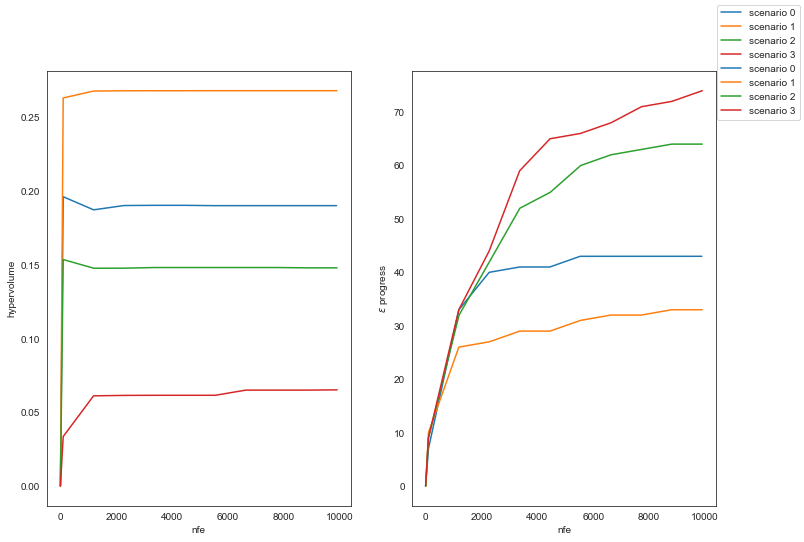

In [38]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
for i, (_, convergence) in enumerate(results):
    ax1.plot(convergence.nfe, convergence.hypervolume, label=f'scenario {i}')
    ax2.plot(convergence.nfe, convergence.epsilon_progress, label=f'scenario {i}')

ax1.set_ylabel('hypervolume')
ax1.set_xlabel('nfe')
ax2.set_ylabel('$\epsilon$ progress')
ax2.set_xlabel('nfe')
fig.legend()
plt.show()

below is a quick visualization of the trade-offs found for each scenario. It does reveal how optimizing under differen scenarios reveals different trade-offs

Note that this is in a way a misleading figure because the scenario under which each of these sets of solutions is being evaluated is not the same.

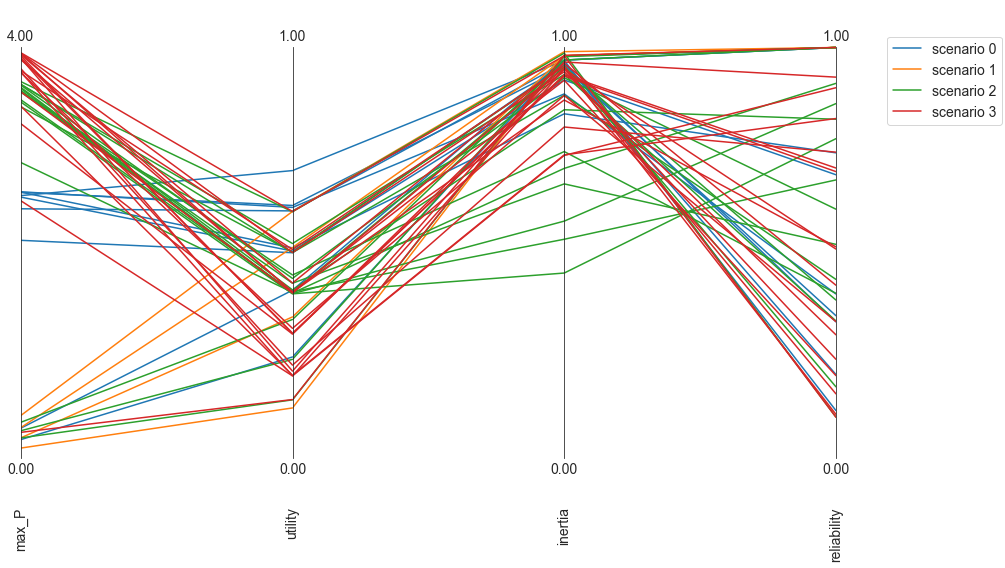

In [50]:
from ema_workbench.analysis import parcoords

colors = iter(sns.color_palette())

data = results[0][0].iloc[:, 5::]
limits = parcoords.get_limits(data)

limits.loc[0, ['inertia', 'reliability']] = 1
limits.loc[0, 'max_P'] = 4 # max over results based on quick inspection not shown here
limits.loc[0, 'utility'] = 1 # max over results based on quick inspection not shown here
limits.loc[1, :] = 0
paraxes = parcoords.ParallelAxes(limits)


for i, (result, _) in enumerate(results):
    color = next(colors)
    data = result.iloc[:, 5::]
    paraxes.plot(data, label=f'scenario {i}', color=color)

paraxes.legend()
plt.show()


## Re-evaluate under deep uncertainty

Combine the pareto set of solutions found for each scenario. Next, turn each solution into a policy object. If you have a very large number of policies, you can choose to down sample your policies in some reasoned way (*e.g.*, picking min and max on each objective, slicing across the pareto front with a particular step size). As a rule of thumb, try to limit the set of policies to at most 50. 

Re-evaluate the combined set of solutions over 1000 scenarios sampled using LHS.


In [58]:
from ema_workbench import Policy

policies = []
for i, (result, _) in enumerate(results):
    result = result.iloc[:, 0:5]
    for j, row in result.iterrows():
        policy = Policy(f'scenario {i} option {j}', **row.to_dict())
        policies.append(policy)

In [60]:
with MultiprocessingEvaluator(model) as evaluator:
    reeevaluation_results = evaluator.perform_experiments(1000, policies=policies)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 46 policies * 1 model(s) = 46000 experiments
[MainProcess/INFO] 4600 cases completed
[MainProcess/INFO] 9200 cases completed
[MainProcess/INFO] 13800 cases completed
[MainProcess/INFO] 18400 cases completed
[MainProcess/INFO] 23000 cases completed
[MainProcess/INFO] 27600 cases completed
[MainProcess/INFO] 32200 cases completed
[MainProcess/INFO] 36800 cases completed
[MainProcess/INFO] 41400 cases completed
[MainProcess/INFO] 46000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


Calculate both the maximum regret, and the domain criterion using the values provided in [Bartholomew and Kwakkel (2020)](https://doi.org/10.1016/j.envsoft.2020.104699). Ignore the max_P objective.

visualize the results in parallel coordinate plot. 

Are there any promising compromise solutions which balance performance in both the reference scenarios as well as in terms of their robustness?


In [91]:
experiments, outcomes = reeevaluation_results

thresholds = {'utility':0.75, 'inertia':0.99, 'reliability':0.8}

overall_scores = {}
for policy in experiments.policy.unique():
    logical = experiments.policy == policy
    scores = {}
    for k, v in outcomes.items():
        try:
            n = np.sum(v[logical]>=thresholds[k])
        except KeyError:
            continue
        scores[k] = n/1000 
    overall_scores[policy] = scores
        
overall_scores = pd.DataFrame(overall_scores).T

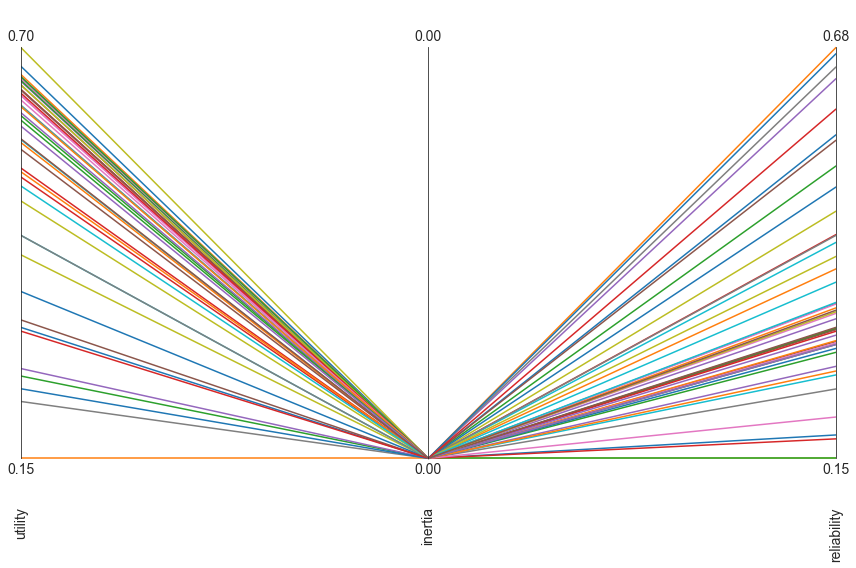

In [92]:
limits = parcoords.get_limits(overall_scores)
paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(overall_scores)
plt.show()

There are many ways of coding the regret calculating. Here I choose to use dataframes. I basically wanted to use the groupby method on a dataframe with the regret for each policy in each scenario. Reasoning backward from there, I arrived at the code shown below. 

There are probably ways of coding this even more efficient. My guess is that a groupby over the scenarios would help in calculating the best performance in each scnenario, avoiding one more explicit loop. I leave this as an exercise for you.

In [120]:
overall_scores = {}
regret = []
for scenario in experiments.scenario.unique():
    logical = experiments.scenario==scenario
    temp_results = {k:v[logical] for k,v in outcomes.items()}
    temp_results = pd.DataFrame(temp_results)
    temp_experiments = experiments[experiments.scenario==scenario]
        
    best = temp_results.max()
    best['max_P'] = temp_results.max_P.min()
    scenario_regret = a - best
    scenario_regret['policy'] = temp_experiments.policy.values    
    regret.append(scenario_regret)


In [121]:
regret = pd.concat(regret)
maxregret = regret.groupby('policy').max()

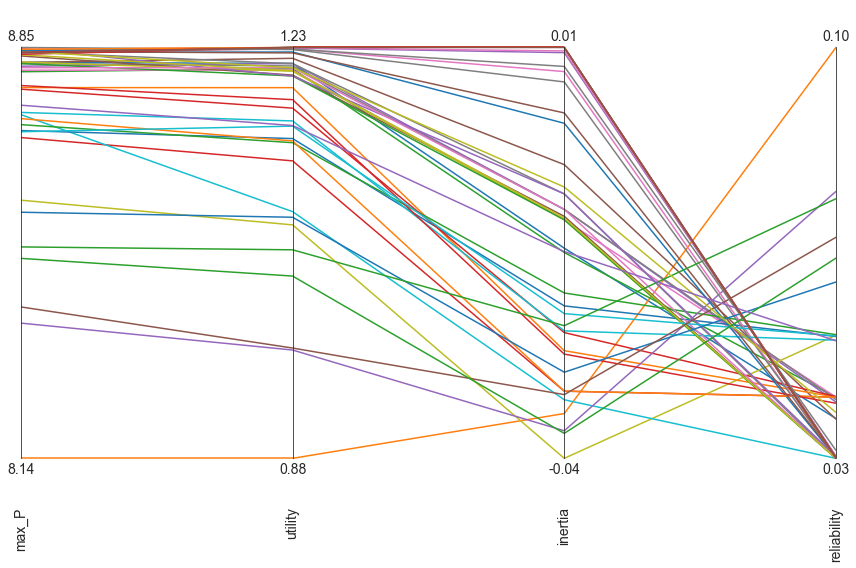

In [123]:
limits = parcoords.get_limits(maxregret)
paraxes = parcoords.ParallelAxes(maxregret)
paraxes.plot(maxregret)
plt.show()